In [36]:
from patchify import patchify
from transformers import SamModel, SamProcessor, SamConfig
import torch
from datasets import Dataset
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import random
import time

from utils import *

In [37]:
paths = {
    'train': {'images':   r"data/ir_data/train/images/",
              'labels':   r'data/ir_data/train/labels/',
              'masks':    r'data/ir_data/train/masks/'},
    'val':   {'images':   r'data/ir_data/val/images/',
              'labels':   r'data/ir_data/val/labels/',
              'masks':    r'data/ir_data/val/masks/'},
    'test':  {'images':   r'data/ir_data/test/images/',
              'labels':   r'data/ir_data/test/labels/',
              'masks':    r'data/ir_data/test/masks/'}
}

train_images, train_bboxes, _ = prepare_data(paths, 'train')
val_images,   val_bboxes,   _ = prepare_data(paths, 'val')
test_images,  test_bboxes,  _ = prepare_data(paths, 'test')

train_correct_masked_images = load_correct_masked_ids('train')
val_correct_masked_images   = load_correct_masked_ids('val')
test_correct_masked_images  = load_correct_masked_ids('test')

all_train_masks = get_all_masks(paths, 'train')
all_val_masks   = get_all_masks(paths, 'val')
all_test_masks  = get_all_masks(paths, 'test')

n_train = len(train_correct_masked_images)
n_val   = len(val_correct_masked_images)
n_test  = len(test_correct_masked_images)

print(f'num train_correct_masked_images: {n_train}')
print(f'num val_correct_masked_images: {n_val}')
print(f'num test_correct_masked_images: {n_test}')

original_dims = (512, 641)

num train_correct_masked_images: 411
num val_correct_masked_images: 102
num test_correct_masked_images: 101


In [38]:
def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)

def prepare_datasets(patch_size: int, image_dims: tuple[int, int]) -> tuple[Dataset, Dataset]:
    step = patch_size

    x_factor = original_dims[1] / image_dims[1]
    y_factor = original_dims[0] / image_dims[0]

    # Combine train and val images as train
    train_img_patches = []
    train_mask_patches = []
    bbox_train = np.zeros((n_train + n_val, 4))

    test_img_patches = []
    test_mask_patches = []
    bbox_test = np.zeros((n_test, 4))

    # Process train images
    i = 0
    for key, seg_model_size in tqdm(train_correct_masked_images.items()):
        # Load and resize image
        img = train_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                train_img_patches.append(single_patch_img)
        
        # Find corresponding mask
        masks = all_train_masks[seg_model_size][key]
        bbox = train_bboxes[key]
        possible_masks = find_mask_in_bbox(masks, bbox)
        
        mask = np.zeros(original_dims)
        for mask_, _ in possible_masks:
            mask = np.logical_or(mask, mask_['segmentation'])
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)
                
        (x, y), w, h = bbox
        bbox_train[i] = (round(x/x_factor), round(y/y_factor), round(w/x_factor), round(h/y_factor))
        
        i += 1

    # Process val images
    for key, seg_model_size in tqdm(val_correct_masked_images.items()):
        # Load and resize image
        img = val_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                train_img_patches.append(single_patch_img)

        # Find corresponding mask
        masks = all_val_masks[seg_model_size][key]
        bbox = val_bboxes[key]
        possible_masks = find_mask_in_bbox(masks, bbox)
        
        mask = np.zeros(original_dims)
        for mask_, _ in possible_masks:
            mask = np.logical_or(mask, mask_['segmentation'])
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)
        
        (x, y), w, h = bbox
        bbox_train[i] = (round(x/x_factor), round(y/y_factor), round(w/x_factor), round(h/y_factor))
        i += 1

    # Process test images
    i = 0
    for key, seg_model_size in tqdm(test_correct_masked_images.items()):
        # Load and resize image
        img = test_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                test_img_patches.append(single_patch_img)

        # Find corresponding mask
        masks = all_test_masks[seg_model_size][key]
        bbox = test_bboxes[key]
        possible_masks = find_mask_in_bbox(masks, bbox)
        
        mask = np.zeros(original_dims)
        for mask_, _ in possible_masks:
            mask = np.logical_or(mask, mask_['segmentation'])
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                test_mask_patches.append(single_patch_mask)
        
        (x, y), w, h = bbox
        bbox_test[i] = (round(x/x_factor), round(y/y_factor), round(w/x_factor), round(h/y_factor))
        i += 1 
        
    X_train = np.array(train_img_patches)
    Y_train = np.array(train_mask_patches)

    X_test = np.array(test_img_patches)
    Y_test = np.array(test_mask_patches)

    # Create a list to store the indices of non-empty masks
    valid_indices = [i for i, mask in enumerate(Y_train) if mask.max() != 0]
    # Filter the image and mask arrays to keep only the non-empty pairs
    X_train = X_train[valid_indices]
    Y_train = Y_train[valid_indices]
    print("Image shape:", X_train.shape)  # e.g., (num_frames, height, width, num_channels)
    print("Mask shape:", Y_train.shape)
    
    # Create a list to store the indices of non-empty masks
    valid_indices = [i for i, mask in enumerate(Y_test) if mask.max() != 0]
    # Filter the image and mask arrays to keep only the non-empty pairs
    X_test = X_test[valid_indices]
    Y_test = Y_test[valid_indices]
    print("Image shape:", X_test.shape)  # e.g., (num_frames, height, width, num_channels)
    print("Mask shape:", Y_test.shape)
    
    # Convert the NumPy arrays to Pillow images and store them in a dictionary
    train_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_train],
        "mask":  [Image.fromarray(mask) for mask in Y_train],
        # "bbox":  bbox_train.tolist(),
    }
    test_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_test],
        "mask":  [Image.fromarray(mask) for mask in Y_test],
        # "bbox":  bbox_test.tolist(),
    }

    # Create the datasets using the datasets.Dataset class
    train_dataset = Dataset.from_dict(train_dict)
    test_dataset  = Dataset.from_dict(test_dict)
    
    return train_dataset, test_dataset

In [39]:
# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map: np.ndarray) -> list[int]:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [40]:
patch_size = 256
image_size = 1024

train_dataset, test_dataset = prepare_datasets(patch_size, (image_size, image_size))

100%|██████████| 101/101 [00:04<00:00, 21.95it/s]


Image shape: (578, 256, 256, 3)
Mask shape: (578, 256, 256)
Image shape: (118, 256, 256, 3)
Mask shape: (118, 256, 256)


In [41]:
train_dataset, test_dataset

(Dataset({
     features: ['image', 'mask'],
     num_rows: 578
 }),
 Dataset({
     features: ['image', 'mask'],
     num_rows: 118
 }))

In [42]:
N_train = len(train_dataset)
N_test  = len(test_dataset)

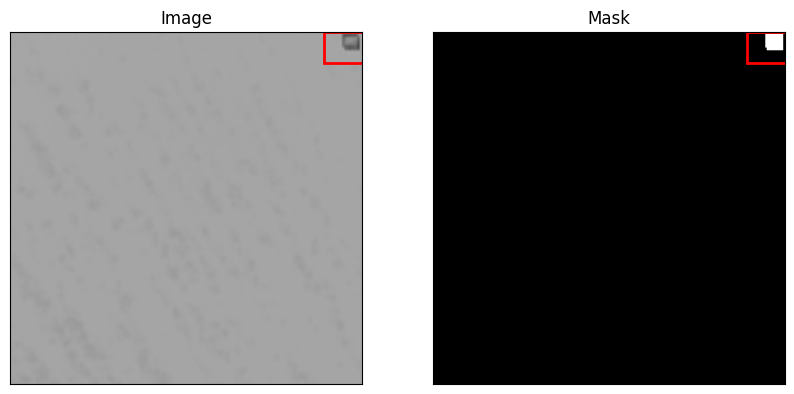

In [43]:
img_num = random.randint(0, N_train-1)
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["mask"]
# example_bbox = train_dataset[img_num]["bbox"]

bbox = get_bounding_box(np.array(example_mask))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the iamge on left
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

# Plot the mask on right
axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    rect_pred = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    # rect_true = Rectangle((example_bbox[0], example_bbox[1]), example_bbox[2], example_bbox[3], linewidth=2, edgecolor='g', facecolor='none')
    
    ax.add_patch(rect_pred)
    # ax.add_patch(rect_true)

plt.show()

In [44]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    Used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        
        ground_truth_mask = np.array(item["mask"])

        # Get bounding box prompt
        # prompt = get_bounding_box(ground_truth_mask)
        prompt = [0, 0, 256, 256]

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [62]:
def load_model_and_processor(image_size: int) -> tuple[SamModel, SamProcessor]:
    # Load the model configuration
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    print(image_size)
    # Create an instance of the model architecture with the loaded configuration
    model = SamModel(config=model_config)
    # Update the model by loading the weights from saved file.
    model.load_state_dict(torch.load(f"sam_checkpoints_finetuned/sam_small_{image_size}.pth"))
    
    return model, processor

def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [64]:
def prepare_image(image: np.ndarray, dims: tuple[int, int]) -> torch.Tensor:
    image = resize_image(image, dims[0], dims[1])
    patches = patchify(np.array(image), (patch_size, patch_size, 3), step=256)
    patches = np.squeeze(patches)
    
    return patches

def predict(model: SamModel, processor: SamProcessor, device: torch.device, image: torch.Tensor, dims: tuple[int, int], thresh: float = 0.5) -> torch.Tensor:
    start_time = time.time()
    model.eval()
    
    patches = prepare_image(image, dims)
    
    pred = None
    prob = None
    
    for row_patches in patches:
        row_pred = None
        row_prob = None
        for patch in row_patches:
            inputs = processor(patch, return_tensors="pt")
            inputs = {k:v.to(device) for k,v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs, multimask_output=False)
                
            single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
            single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
            single_patch_prediction = (single_patch_prob > thresh).astype(np.uint8)

            if row_pred is None and row_prob is None:
                row_pred = single_patch_prediction
                row_prob = single_patch_prob
            else:
                row_pred = np.concatenate((row_pred, single_patch_prediction), axis=1)
                row_prob = np.concatenate((row_prob, single_patch_prob), axis=1)
                
        if pred is None and prob is None:
            pred = row_pred
            prob = row_prob
        else:
            pred = np.concatenate((pred, row_pred), axis=0)
            prob = np.concatenate((prob, row_prob), axis=0)
    
    end_time = time.time()
    print(f"Time taken to predict: {end_time - start_time:.2f} seconds")
    
    return pred, prob

def plot_prediction(image: np.ndarray, prediction: np.ndarray, probability: np.ndarray, idx: int) -> None:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title(idx)

    # Plot the second image on the right
    axes[1].imshow(probability)  # Assuming the second image is grayscale
    axes[1].set_title("Probability Map")

    # Plot the second image on the right
    axes[2].imshow(prediction, cmap='gray')  # Assuming the second image is grayscale
    axes[2].set_title("Prediction")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()

In [65]:
device = get_device()

models = {}
processors = {}

for size in [512, 1024, 2048]:
    model, processor = load_model_and_processor(size)
    model.to(device)
    models[size] = model
    processors[size] = processor

512
1024
2048


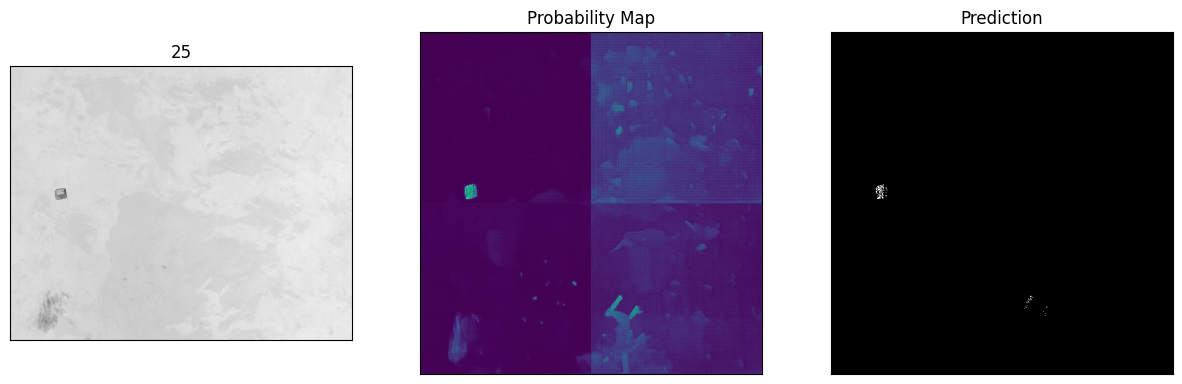

In [70]:
# idx = random.randint(1, len(test_images))
idx = 25
test_image = test_images[idx]

image_size = 512

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.4)
plot_prediction(test_image, pred, prob, idx)

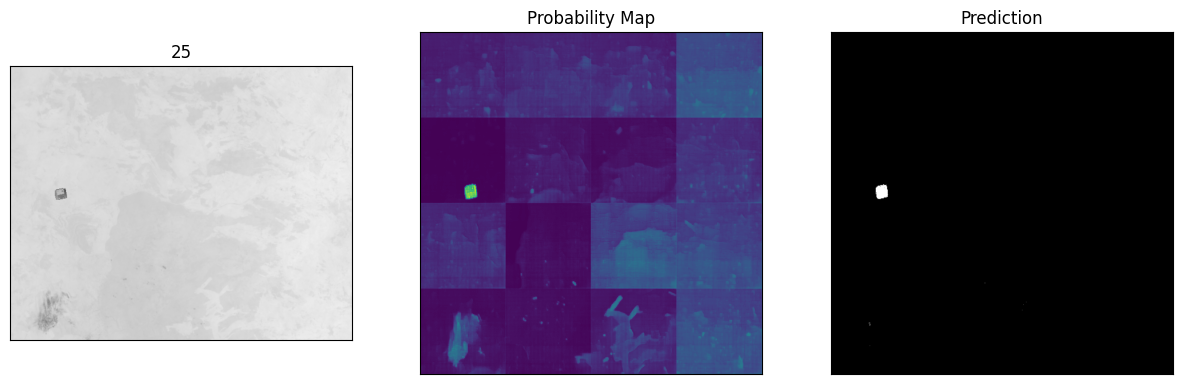

In [71]:
idx = 25
test_image = test_images[idx]

image_size = 1024

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.4)
plot_prediction(test_image, pred, prob, idx)

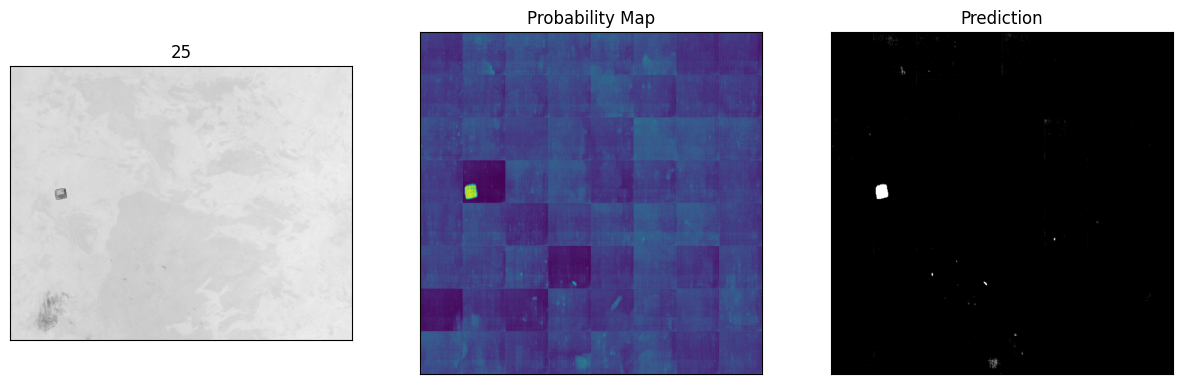

In [72]:
idx = 25
test_image = test_images[idx]

image_size = 2048

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.4)
plot_prediction(test_image, pred, prob, idx)

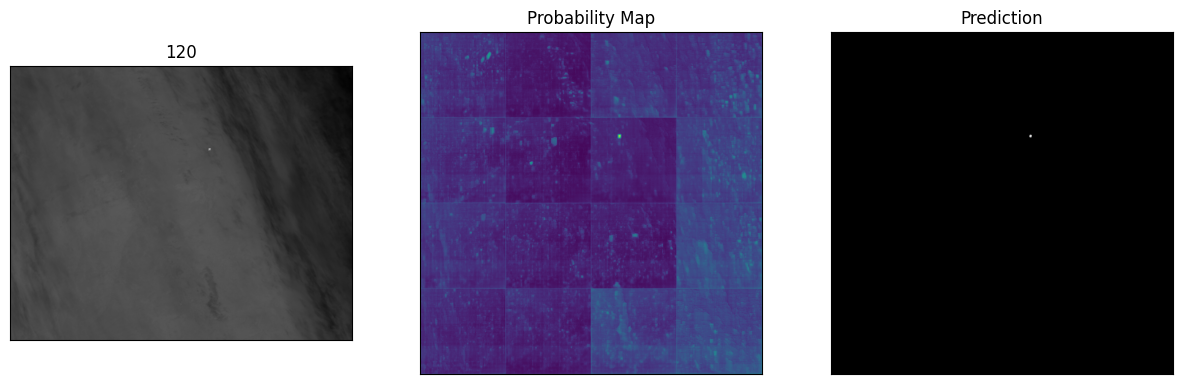

In [55]:
idx = random.randint(1, len(test_images))
test_image = test_images[idx]

pred, prob = predict(model, processor, device, test_image, thresh=0.4)
plot_prediction(test_image, pred, prob, idx)

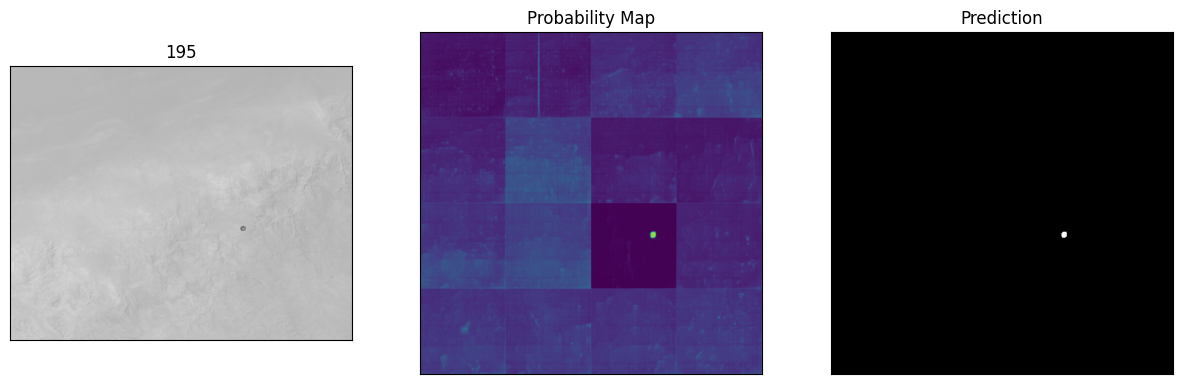

In [59]:
idx = random.randint(1, len(test_images))
test_image = test_images[idx]

pred, prob = predict(model, processor, device, test_image, thresh=0.4)
plot_prediction(test_image, pred, prob, idx)